In [4]:
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
import random 
from glob import glob
import sklearn

from tqdm.autonotebook import tqdm
from sklearn.metrics import average_precision_score, roc_auc_score
from pathlib import Path

#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

# opensoundscape transfer learning tools
from opensoundscape.ml.shallow_classifier import MLPClassifier, quick_fit, fit_classifier_on_embeddings
import os
from pathlib import Path
from pydub import AudioSegment

In [5]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [6]:
import os
from pathlib import Path
import pandas as pd

# Define dataset path
dataset_path = Path("/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/engine_5sec/")
train_path = dataset_path / "train_5sec"

# Function to traverse directories and map file information to labels
def traverse_and_map(directory, label):
    audio_files = []
    labels = []
    start_times = []
    end_times = []
    
    if not directory.exists():
        print(f"Directory does not exist: {directory}")
        return pd.DataFrame()  # Return empty DataFrame if directory doesn't exist
    
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".wav"):
                # Prepend full dataset path to the file path
                audio_path = dataset_path / Path(root).relative_to(dataset_path) / file
                audio_files.append(str(audio_path))
                labels.append(label)
                start_times.append(0.0)  # Fixed start time
                end_times.append(5.0)   # Fixed end time

    # Create DataFrame for the current directory
    data = {
        "file": audio_files,
        "start_time": start_times,
        "end_time": end_times,
        "A": labels
    }
    return pd.DataFrame(data)

# Initialize a dictionary to hold DataFrames for each training size
labels_trains = {}

# Iterate over each train size folder
if train_path.exists():
    for train_size_dir in train_path.iterdir():
        if train_size_dir.is_dir():  # Ensure it's a directory
            training_size = train_size_dir.name  # Get the name of the training size directory

            # Process `pos` and `neg` subdirectories
            pos_dir = train_size_dir / "pos"
            neg_dir = train_size_dir / "neg"
            df_pos = traverse_and_map(pos_dir, 1)  # 1 for "pos" files
            df_neg = traverse_and_map(neg_dir, 0)  # 0 for "negative" files

            # Combine the DataFrames for `pos` and `neg`
            combined_df = pd.concat([df_pos, df_neg], ignore_index=True)

            # Set MultiIndex with 'file', 'start_time', and 'end_time'
            combined_df.set_index(["file", "start_time", "end_time"], inplace=True)

            # Rename the only column to "A"
            combined_df.columns = ['A']

            # Store the DataFrame in the dictionary
            labels_trains[training_size] = combined_df

            # Optionally, save each DataFrame to a CSV file
            output_path = dataset_path / f"labels_trains_{training_size}.csv"
            combined_df.to_csv(output_path)
            print(f"DataFrame saved for training size {training_size}: {output_path}")
else:
    print(f"Train path does not exist: {train_path}")

# Display the DataFrames for verification
for training_size, df in labels_trains.items():
    print(f"\nDataFrame for training size {training_size}:")
    print(df.head())


DataFrame saved for training size train_size_25: /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/engine_5sec/labels_trains_train_size_25.csv
DataFrame saved for training size train_size_75: /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/engine_5sec/labels_trains_train_size_75.csv
DataFrame saved for training size train_size_100: /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/engine_5sec/labels_trains_train_size_100.csv
DataFrame saved for training size train_size_50: /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/engine_5sec/labels_trains_train_size_50.csv

DataFrame for training size train_size_25:
                                                                        A
file                                               start_time end_time   
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train...

Processing data for training set

In [8]:
labels_trains['train_size_100'].head(20)

,,,A
file,start_time,end_time,
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/engine_5sec/train_5sec/train_size_100/pos/engine_470.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/engine_5sec/train_5sec/train_size_100/pos/engine_114.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/engine_5sec/train_5sec/train_size_100/pos/engine_12.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/engine_5sec/train_5sec/train_size_100/pos/engine_303.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/engine_5sec/train_5sec/train_size_100/pos/engine_513.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/engine_5sec/train_5sec/train_size_100/pos/engine_112.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/engine_5sec/train_5sec/train_size_100/pos/engine_113.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/engine_5sec/train_5sec/train_size_100/pos/engine_110.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/engine_5sec/train_5sec/train_size_100/pos/engine_474.wav,0.0,5.0,1


Prepare audio Data

Step 1: Train shallow classifier on Perch embeddings

In [9]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


Step 2: Generate embeddings on the training and validation data

Training size 25

In [10]:
emb_train_25 = model.embed(labels_trains['train_size_25'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/2 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1

In [11]:
csv_path = Path("/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/engine_5sec/test_5sec/test_dataset_5sec.csv")
audio_file_path = Path("/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/engine_5sec/test_5sec/test_dataset_5sec.wav")
output_folder = Path("/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/engine_5sec/test_5sec/clips")
output_csv_dir = Path("/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/engine_5sec/test_5sec/")
output_csv = output_csv_dir / "processed_test_dataset_5sec.csv"

# Ensure the output directories exist
output_folder.mkdir(parents=True, exist_ok=True)
output_csv_dir.mkdir(parents=True, exist_ok=True)

# Read the CSV file
df_csv = pd.read_csv(csv_path)

# Determine label based on conditions
df_csv["A"] = df_csv.apply(
    lambda row: 1 if row["label"] == 1 else 0, axis=1
)

# Load the audio file
audio = AudioSegment.from_file(audio_file_path)

# Initialize lists for DataFrame creation
file_paths = []
start_times = []
end_times = []
labels = []

# Partition the audio file into 5-second clips based on CSV
for index, row in df_csv.iterrows():
    start_time = index * 5 * 1000  # in milliseconds
    end_time = start_time + 5 * 1000  # 3 seconds later

    # Extract clip
    clip = audio[start_time:end_time]

    # Save clip to the output folder
    #WT does not have unique row identifier filename column
    filename = row["sound"]
    clip_path = output_folder / filename
    clip.export(clip_path, format="wav")

    # Add details to lists
    file_paths.append(str(clip_path))
    start_times.append(0.0)  
    end_times.append(5.0)  
    labels.append(row["A"])

# Create the DataFrame
df_processed = pd.DataFrame({
    "file": file_paths,
    "start_time": start_times,
    "end_time": end_times,
    "A": labels
})
df_processed.set_index(["file", "start_time", "end_time"], inplace=True)
df_processed.columns = ['A']
# Save the DataFrame to a CSV file
df_processed.to_csv(output_csv, index=False)

print(f"Processed dataset saved to {output_csv}")
print(f"Audio clips saved to {output_folder}")
print(df_processed.head())

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_56535/3573880619.py:20: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/engine_5sec/test_5sec/test_dataset_5sec.wav'>
  audio = AudioSegment.from_file(audio_file_path)
/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_56535/3573880619.py:40: ResourceWarning: unclosed file <_io.BufferedRandom name='/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/engine_5sec/test_5sec/clips/engine_327.wav'>
  clip.export(clip_path, format="wav")
/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_56535/3573880619.py:40: ResourceWarning: unclosed file <_io.BufferedRandom name='/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/engine_5sec/test_5sec/clips/engine_6.wav'>
  clip.export(clip_path, format="wav")
/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_56535/3573880619.py:40: ResourceWarning: unclosed file <_io.BufferedRandom name='/

Processed dataset saved to /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/engine_5sec/test_5sec/processed_test_dataset_5sec.csv
Audio clips saved to /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/engine_5sec/test_5sec/clips
                                                                        A
file                                               start_time end_time   
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       0
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       0
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       0
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       1


In [12]:
labels_val = df_processed

In [13]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/2 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.992 sec instead of 5.0 sec
  warnings.warn(error_msg)


In [14]:
emb_train_25 = torch.tensor(emb_train_25, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)

# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_25.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_25 = emb_train_25.view(emb_train_25.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_25: {emb_train_25.shape}")
print(f"Reshaped emb_val: {emb_val.shape}")

Original shape of emb_train: torch.Size([50, 512])
Reshaped emb_train_25: torch.Size([50, 1, 32, 16])
Reshaped emb_val: torch.Size([50, 1, 32, 16])


In [15]:
import torch.nn as nn

if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [16]:
emb_train_25 = emb_train_25.repeat(1, 3, 1, 1)  # Duplicate to 3 channels
emb_val = emb_val.repeat(1, 3, 1, 1)

In [17]:
import torch.nn as nn

model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [18]:
quick_fit(model.network, emb_train_25, labels_trains['train_size_25'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 2.1911391741014086e-05, Val Loss: 1.576308012008667
val AU ROC: 0.821
val MAP: 0.821
Epoch 200/1000, Loss: 1.544508631923236e-05, Val Loss: 1.641499638557434
val AU ROC: 0.805
val MAP: 0.805
Epoch 300/1000, Loss: 1.2556743058667053e-05, Val Loss: 1.666648268699646
val AU ROC: 0.791
val MAP: 0.791
Epoch 400/1000, Loss: 1.0691848729038611e-05, Val Loss: 1.6919788122177124
val AU ROC: 0.790
val MAP: 0.790
Epoch 500/1000, Loss: 9.34874242375372e-06, Val Loss: 1.716304063796997
val AU ROC: 0.791
val MAP: 0.791
Epoch 600/1000, Loss: 8.23450227471767e-06, Val Loss: 1.7369304895401
val AU ROC: 0.792
val MAP: 0.792
Epoch 700/1000, Loss: 7.33040315026301e-06, Val Loss: 1.7529674768447876
val AU ROC: 0.792
val MAP: 0.792
Epoch 800/1000, Loss: 6.6034340306941886e-06, Val Loss: 1.765120029449463
val AU ROC: 0.794
val MAP: 0.794
Epoch 900/1000, Loss: 5.988627890474163e-06, Val Loss: 1.778355598449707
val AU ROC: 0.793
val MAP: 0.793
Epoch 1000/1000, Loss: 5.483255336002912e-06,

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_56535/1842857064.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


0.8400000000000001

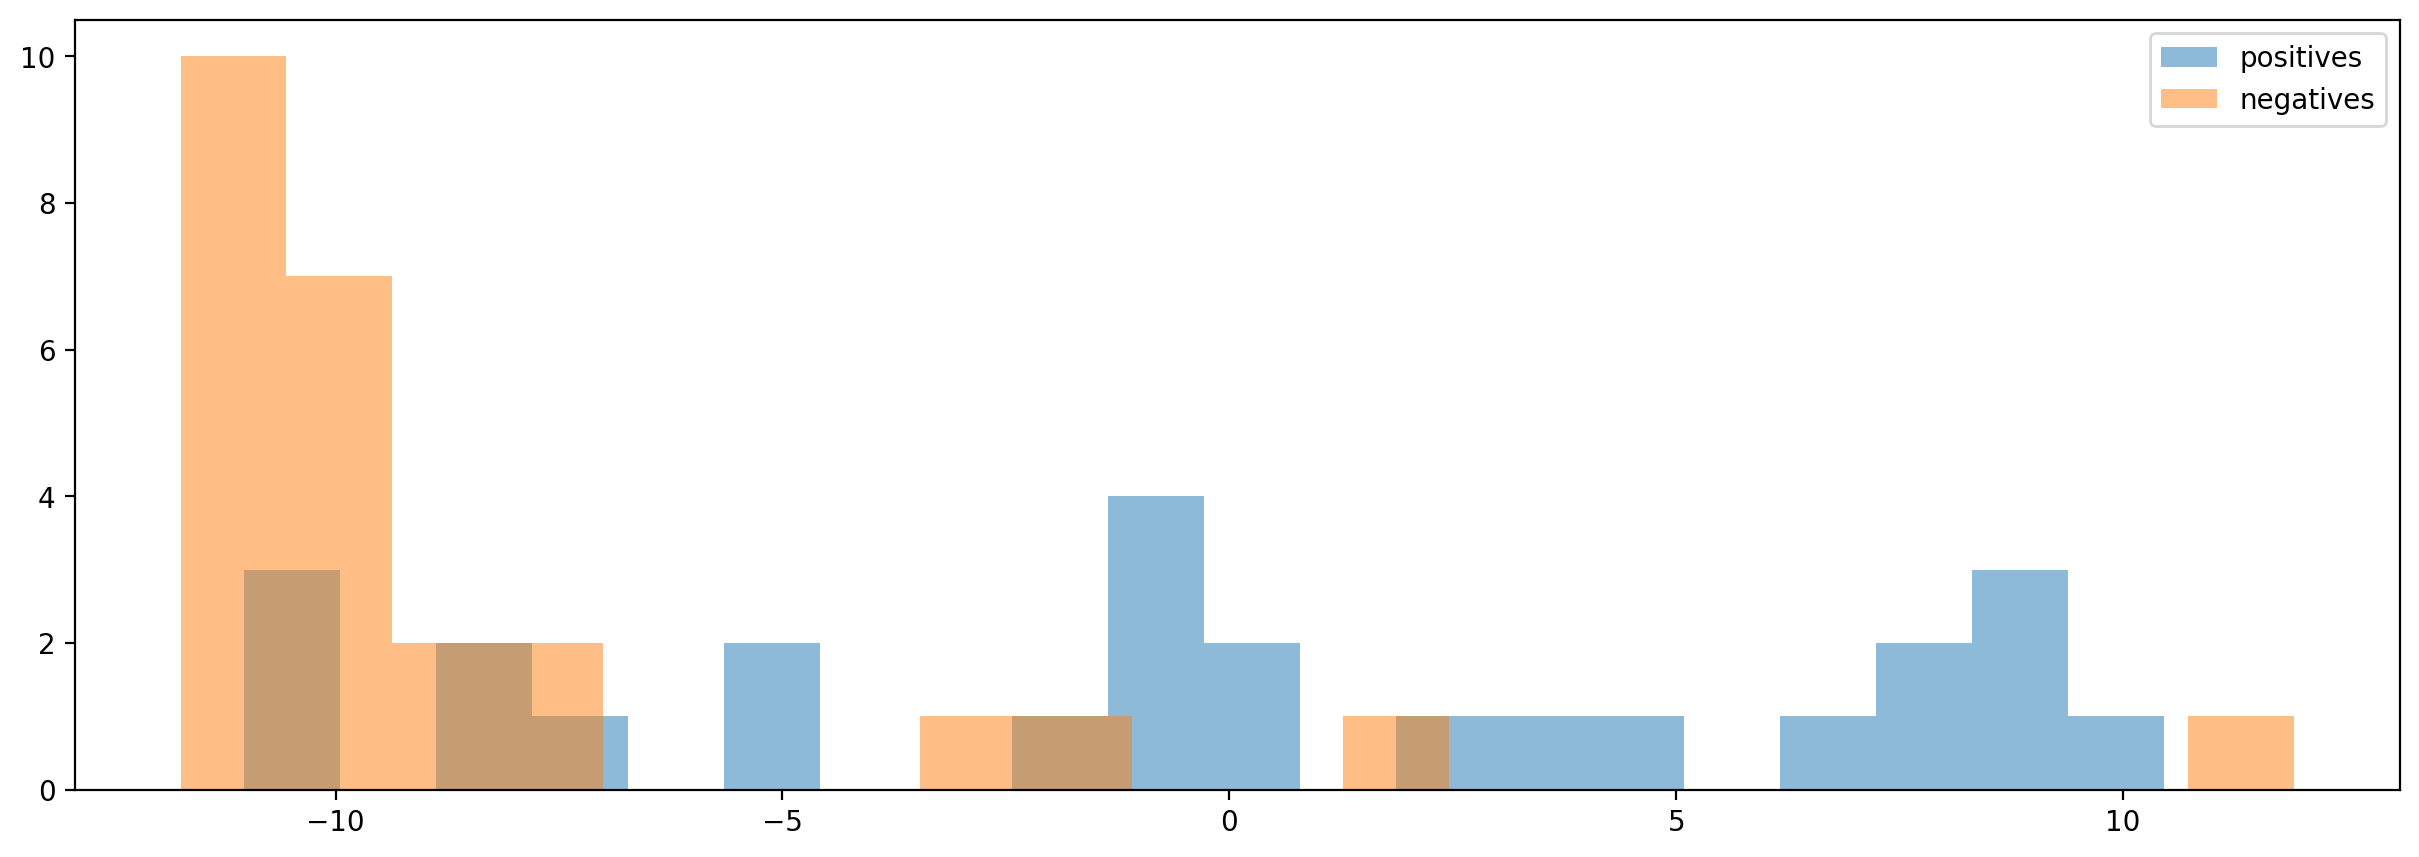

In [19]:
# make predictions by passing the embeddings through the classifier
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_25 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_25

Training size 50

In [20]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [21]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/2 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.992 sec instead of 5.0 sec
  warnings.warn(error_msg)


In [22]:
emb_train_50 = model.embed(labels_trains['train_size_50'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1

In [23]:
emb_train_50 = torch.tensor(emb_train_50, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)

# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_50.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_50 = emb_train_50.view(emb_train_50.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_50: {emb_train_50.shape}")

Original shape of emb_train: torch.Size([100, 512])
Reshaped emb_train_50: torch.Size([100, 1, 32, 16])


In [24]:
import torch.nn as nn

if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [25]:
emb_train_50 = emb_train_50.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [26]:
import torch.nn as nn

model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [27]:
quick_fit(model.network, emb_train_50, labels_trains['train_size_50'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 5.1057002565357834e-05, Val Loss: 1.7749313116073608
val AU ROC: 0.877
val MAP: 0.877
Epoch 200/1000, Loss: 3.200923674739897e-05, Val Loss: 1.7947955131530762
val AU ROC: 0.879
val MAP: 0.879
Epoch 300/1000, Loss: 2.254578248539474e-05, Val Loss: 1.8264425992965698
val AU ROC: 0.875
val MAP: 0.875
Epoch 400/1000, Loss: 1.6792539099697024e-05, Val Loss: 1.8587878942489624
val AU ROC: 0.875
val MAP: 0.875
Epoch 500/1000, Loss: 1.281474487768719e-05, Val Loss: 1.8882179260253906
val AU ROC: 0.875
val MAP: 0.875
Epoch 600/1000, Loss: 9.91390334093012e-06, Val Loss: 1.9287234544754028
val AU ROC: 0.876
val MAP: 0.876
Epoch 700/1000, Loss: 8.023359441722278e-06, Val Loss: 1.9519115686416626
val AU ROC: 0.879
val MAP: 0.879
Epoch 800/1000, Loss: 6.800368282711133e-06, Val Loss: 1.9559533596038818
val AU ROC: 0.884
val MAP: 0.884
Epoch 900/1000, Loss: 5.6867011153372005e-06, Val Loss: 1.9708993434906006
val AU ROC: 0.884
val MAP: 0.884
Epoch 1000/1000, Loss: 4.8800611693

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_56535/2687331274.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


0.8479999999999999

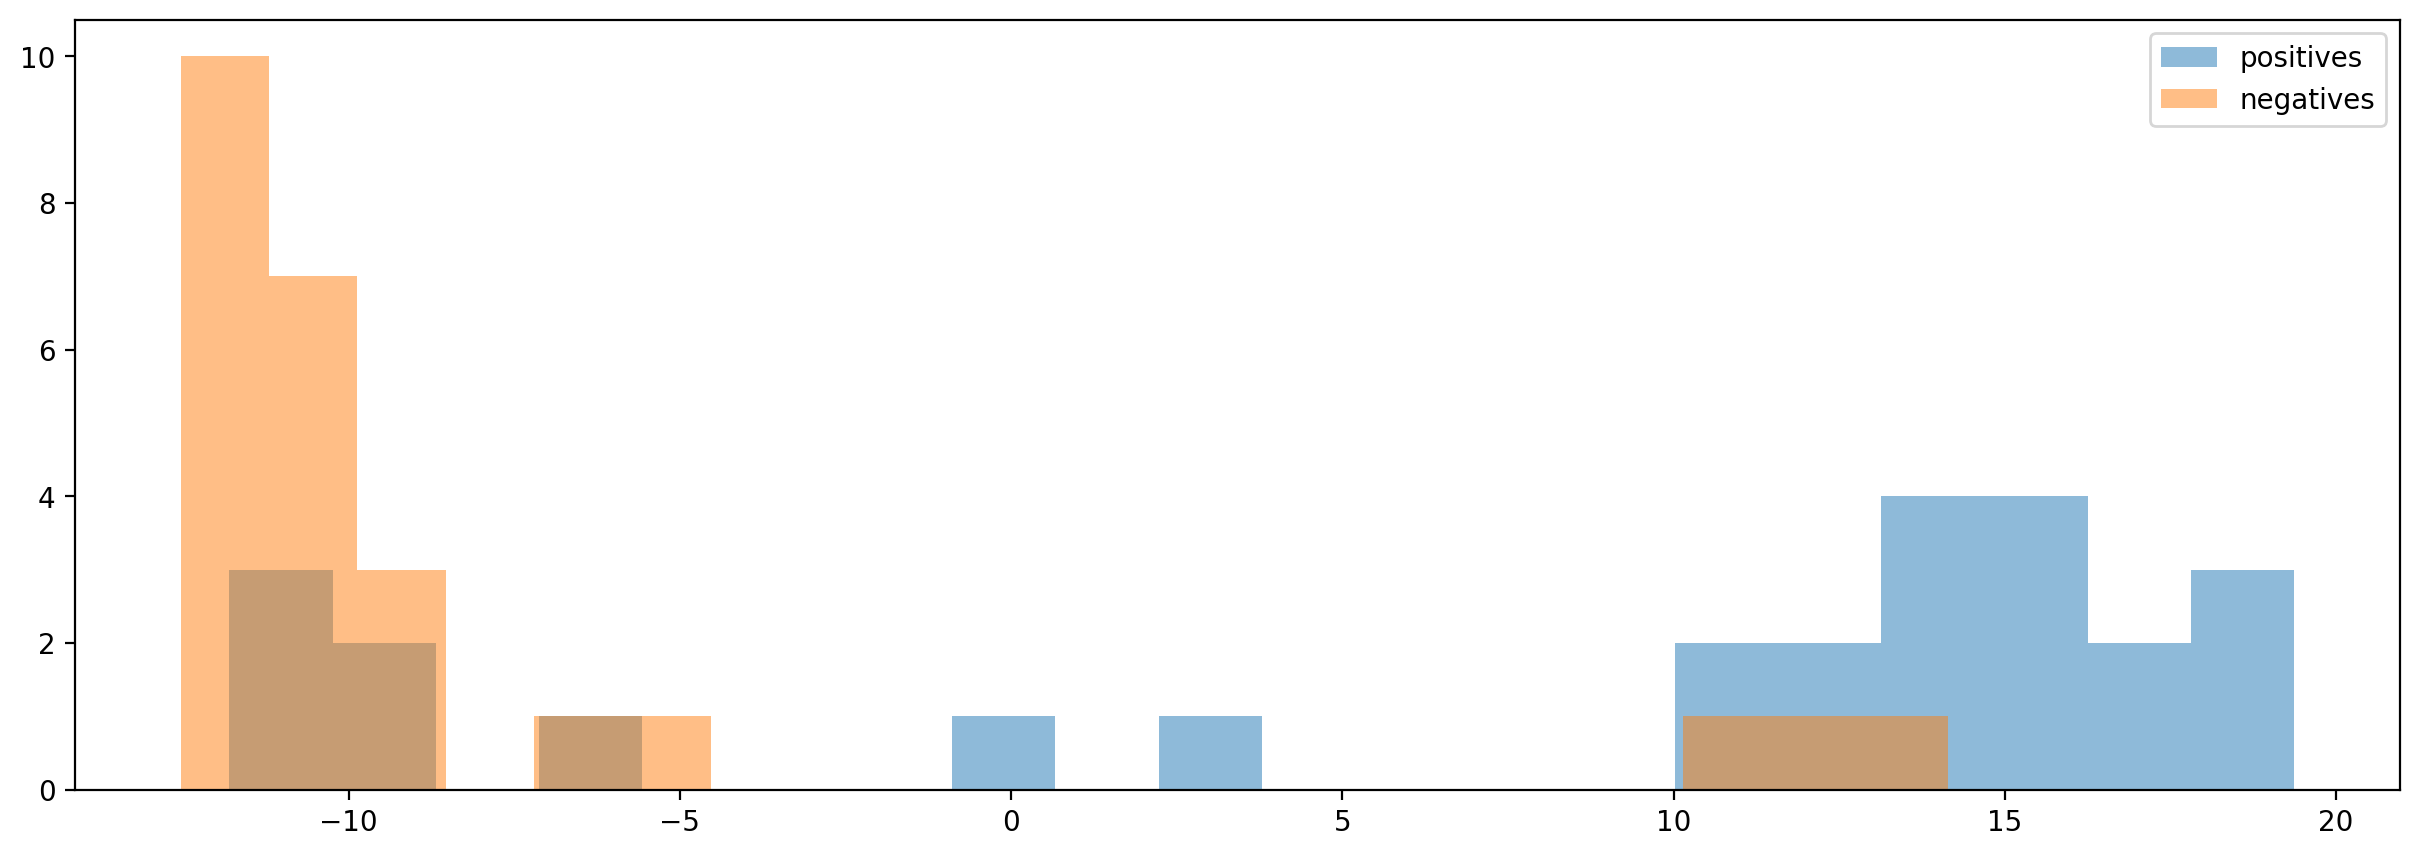

In [28]:
# make predictions by passing the embeddings through the classifier
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_50 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_50

Training size 75

In [29]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [30]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/2 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.992 sec instead of 5.0 sec
  warnings.warn(error_msg)


In [31]:
emb_train_75 = model.embed(labels_trains['train_size_75'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1

In [32]:
emb_train_75 = torch.tensor(emb_train_75, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)

# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_75.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_75 = emb_train_75.view(emb_train_75.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_75: {emb_train_75.shape}")

Original shape of emb_train: torch.Size([150, 512])
Reshaped emb_train_75: torch.Size([150, 1, 32, 16])


In [33]:
import torch.nn as nn

if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [34]:
emb_train_75 = emb_train_75.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [35]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [36]:
quick_fit(model.network, emb_train_75, labels_trains['train_size_75'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 2.7771806344389915e-05, Val Loss: 1.8364791870117188
val AU ROC: 0.863
val MAP: 0.863
Epoch 200/1000, Loss: 1.6229845641646534e-05, Val Loss: 1.9149714708328247
val AU ROC: 0.836
val MAP: 0.836
Epoch 300/1000, Loss: 1.2094882549718022e-05, Val Loss: 1.927787184715271
val AU ROC: 0.848
val MAP: 0.848
Epoch 400/1000, Loss: 9.705433512863237e-06, Val Loss: 1.9165465831756592
val AU ROC: 0.865
val MAP: 0.865
Epoch 500/1000, Loss: 8.027279363886919e-06, Val Loss: 1.9189651012420654
val AU ROC: 0.867
val MAP: 0.867
Epoch 600/1000, Loss: 6.800732990086544e-06, Val Loss: 1.9176439046859741
val AU ROC: 0.868
val MAP: 0.868
Epoch 700/1000, Loss: 5.815474651171826e-06, Val Loss: 1.9365664720535278
val AU ROC: 0.866
val MAP: 0.866
Epoch 800/1000, Loss: 5.095602318760939e-06, Val Loss: 1.9534684419631958
val AU ROC: 0.860
val MAP: 0.860
Epoch 900/1000, Loss: 4.3687750803655945e-06, Val Loss: 1.9730229377746582
val AU ROC: 0.860
val MAP: 0.860
Epoch 1000/1000, Loss: 3.841907073

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_56535/4227207383.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


0.824

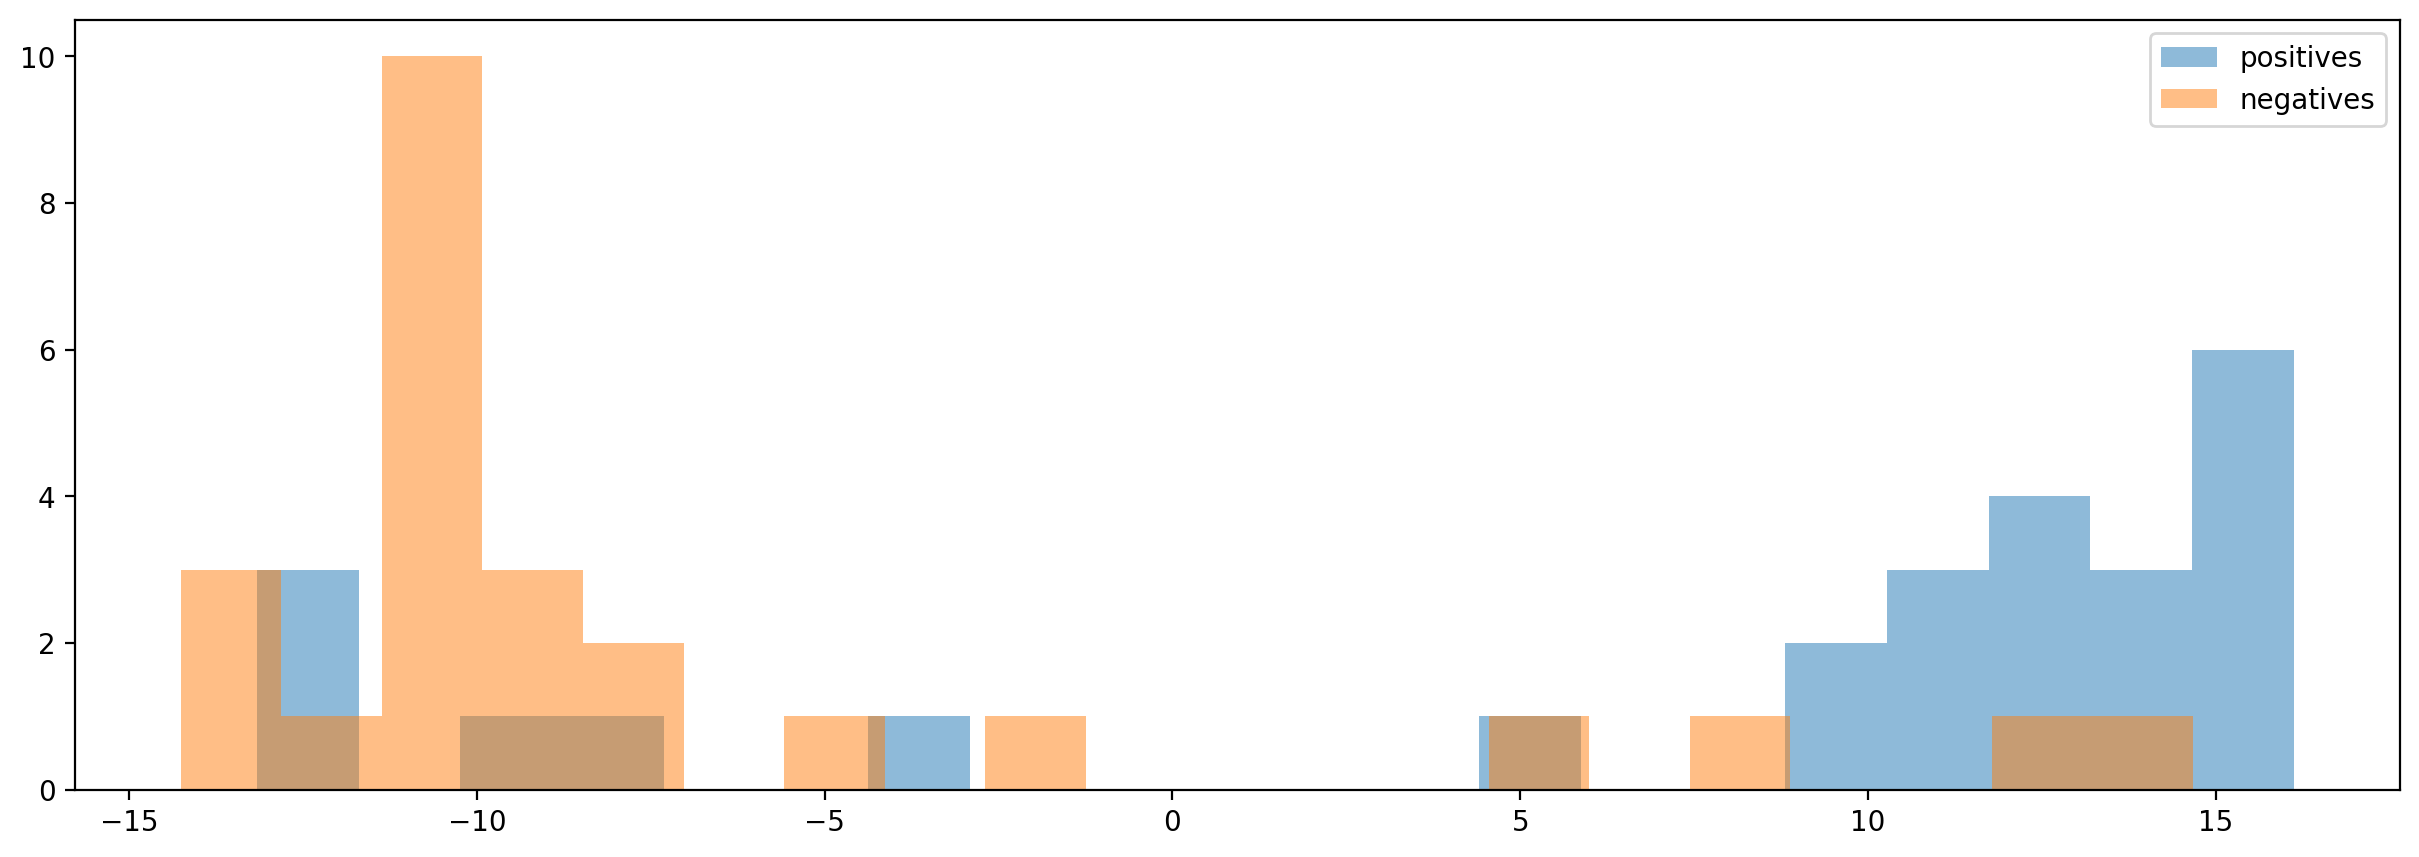

In [37]:
# make predictions by passing the embeddings through the classifier
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_75 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_75

Training size 100

In [38]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [39]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/2 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.992 sec instead of 5.0 sec
  warnings.warn(error_msg)


In [40]:
emb_train_100 = model.embed(labels_trains['train_size_100'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/7 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1

In [41]:
emb_train_100 = torch.tensor(emb_train_100, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)
# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_100.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_100 = emb_train_100.view(emb_train_100.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)
# Verify the reshaped embeddings
print(f"Reshaped emb_train_100: {emb_train_100.shape}")

Original shape of emb_train: torch.Size([200, 512])
Reshaped emb_train_100: torch.Size([200, 1, 32, 16])


In [42]:
if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [43]:
emb_train_100 = emb_train_100.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [44]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [45]:
quick_fit(model.network, emb_train_100, labels_trains['train_size_100'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 1.327838072029408e-05, Val Loss: 1.1289461851119995
val AU ROC: 0.916
val MAP: 0.916
Epoch 200/1000, Loss: 8.959715160017367e-06, Val Loss: 1.2051403522491455
val AU ROC: 0.908
val MAP: 0.908
Epoch 300/1000, Loss: 7.177318821049994e-06, Val Loss: 1.2710156440734863
val AU ROC: 0.904
val MAP: 0.904
Epoch 400/1000, Loss: 6.082649179006694e-06, Val Loss: 1.3136639595031738
val AU ROC: 0.899
val MAP: 0.899
Epoch 500/1000, Loss: 5.27377460457501e-06, Val Loss: 1.3483134508132935
val AU ROC: 0.894
val MAP: 0.894
Epoch 600/1000, Loss: 4.6320683395606466e-06, Val Loss: 1.3813824653625488
val AU ROC: 0.891
val MAP: 0.891
Epoch 700/1000, Loss: 4.09107587984181e-06, Val Loss: 1.4134037494659424
val AU ROC: 0.886
val MAP: 0.886
Epoch 800/1000, Loss: 3.71970941159816e-06, Val Loss: 1.4442027807235718
val AU ROC: 0.887
val MAP: 0.887
Epoch 900/1000, Loss: 3.2825471407704754e-06, Val Loss: 1.4717762470245361
val AU ROC: 0.886
val MAP: 0.886
Epoch 1000/1000, Loss: 3.0050482564547

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_56535/1406550891.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


0.8896

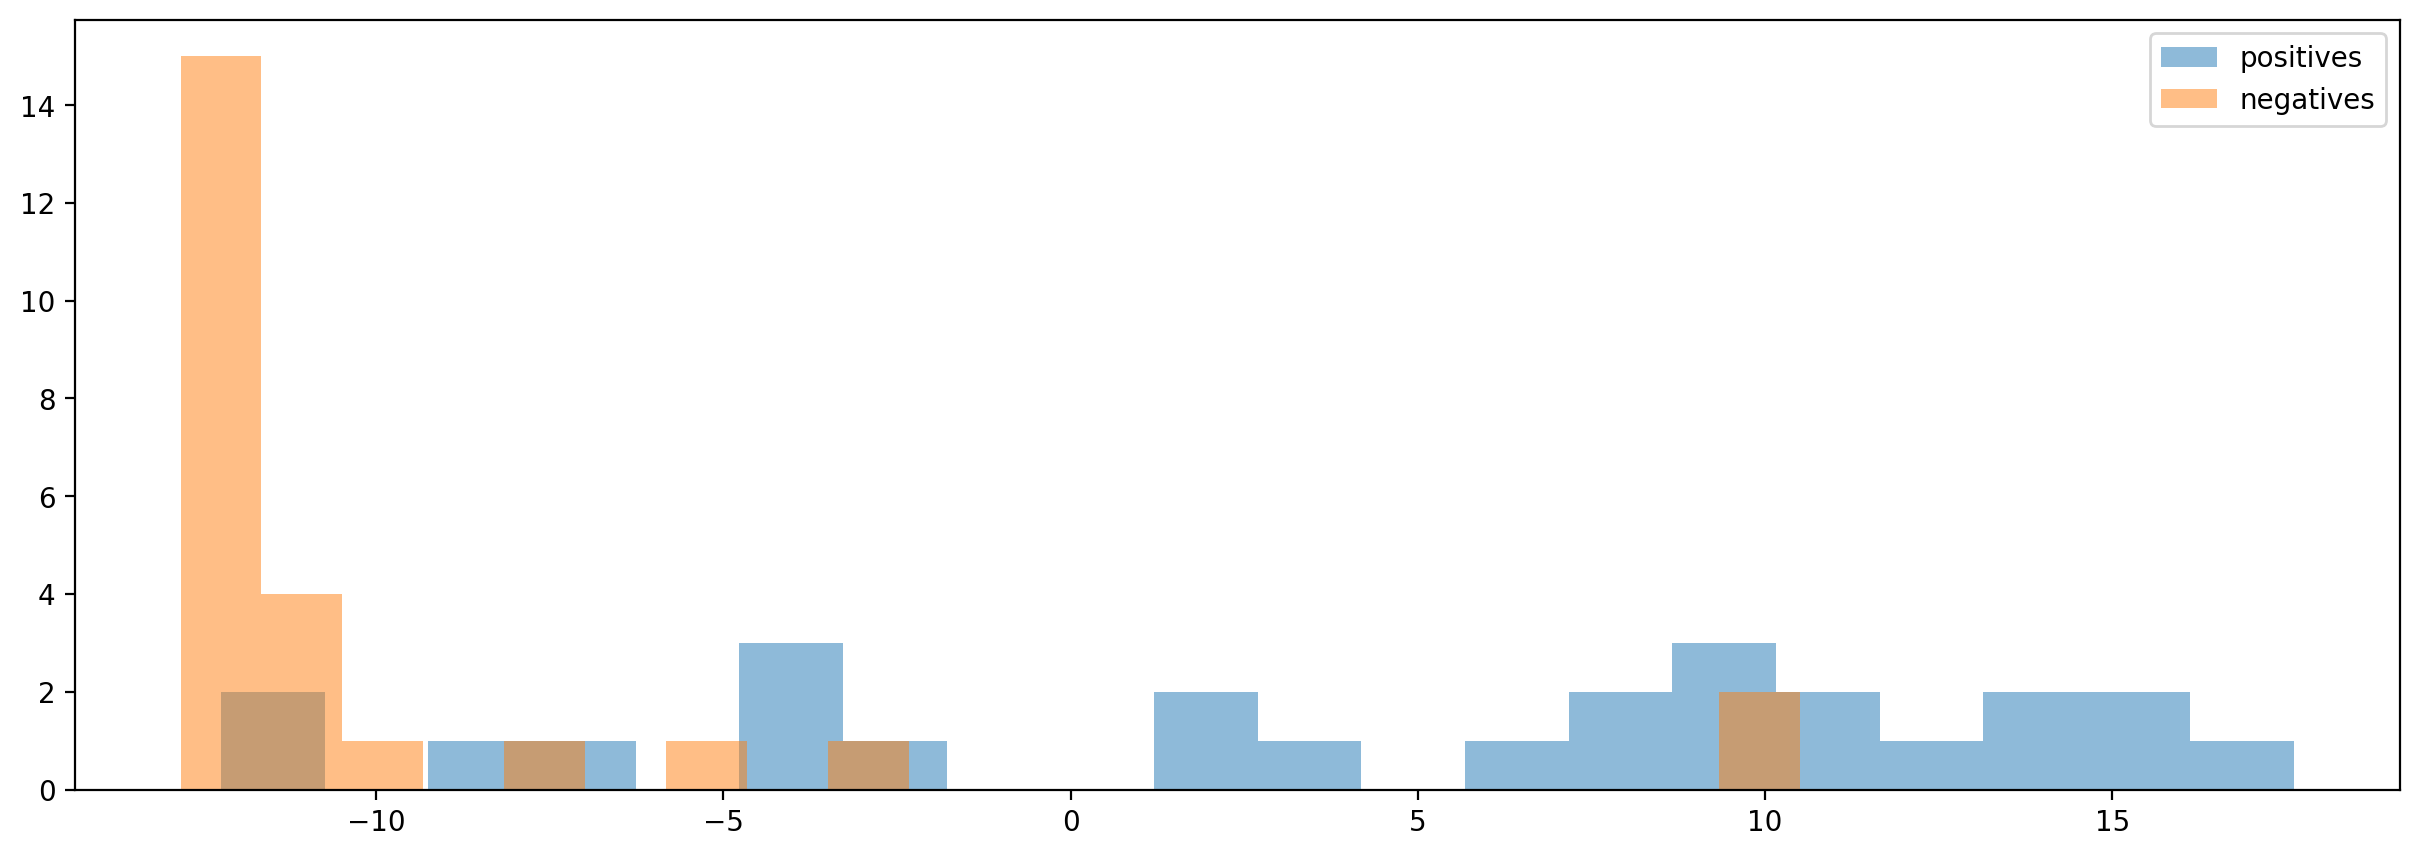

In [46]:
# make predictions by passing the embeddings through the classifier
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_100 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_100

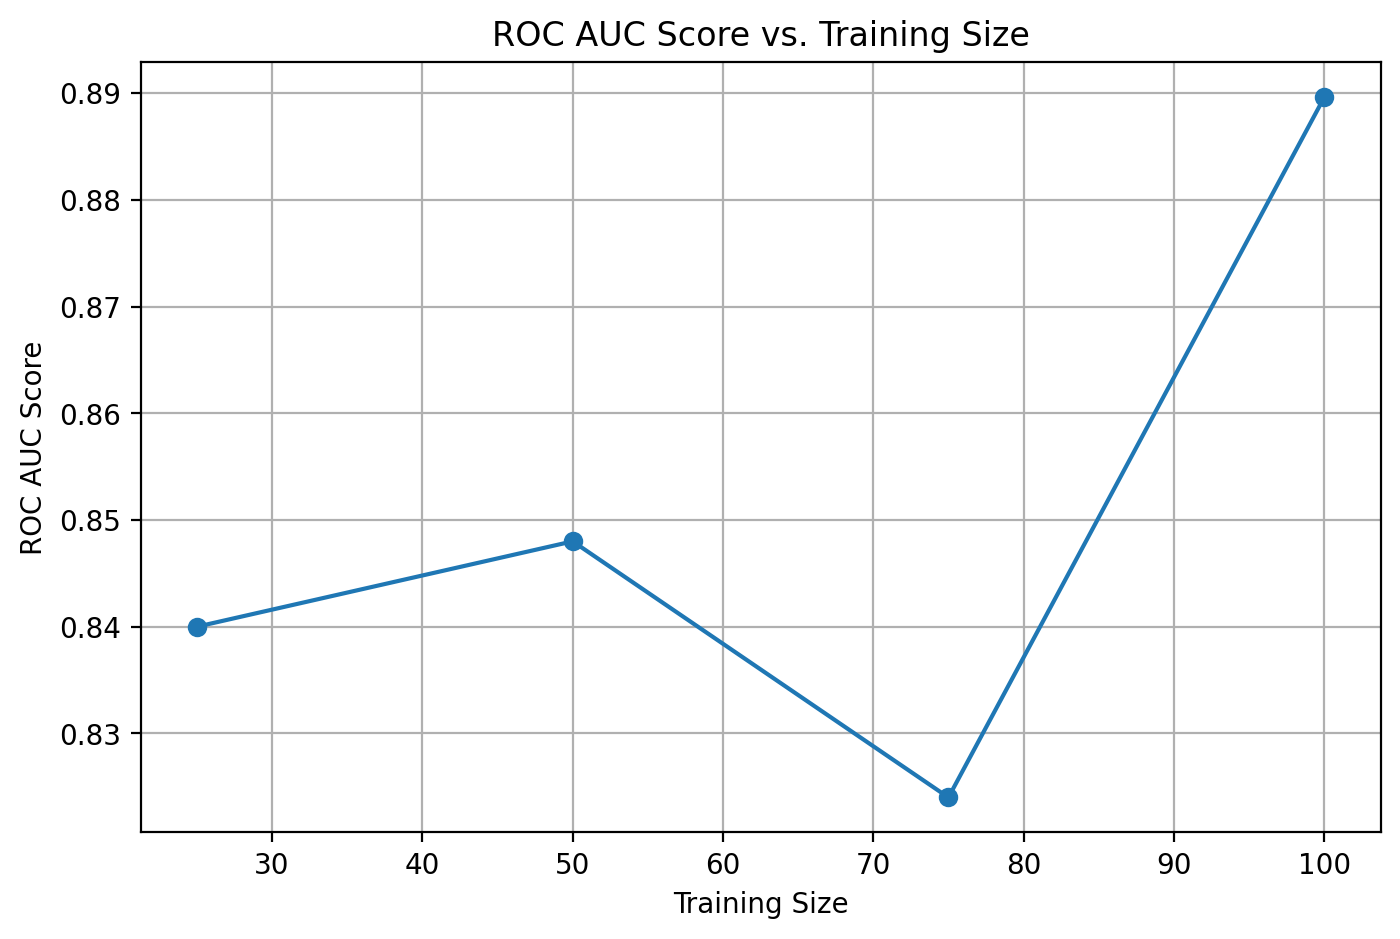

In [47]:
training_sizes = []
roc_auc_scores = []

# Iterate over training sizes and collect the scores
for size in range(25, 101, 25):
    score = eval(f"roc_auc_score_{size}")
    training_sizes.append(size)
    roc_auc_scores.append(score)

# Create a DataFrame
df = pd.DataFrame({"Training Size": training_sizes, "ROC AUC Score": roc_auc_scores})


# Plot a line plot
plt.figure(figsize=(8, 5))
plt.plot(df["Training Size"], df["ROC AUC Score"], marker='o', linestyle='-')
plt.title("ROC AUC Score vs. Training Size")
plt.xlabel("Training Size")
plt.ylabel("ROC AUC Score")
plt.grid(True)
plt.show()